In [4]:
%matplotlib notebook
import numpy as np
import gdcm
import matplotlib.pyplot as plt
import sys

In [5]:
def _gdcm_to_numpy(image):
    """ Converts a GDCM image to a numpy array.
    :param image: GDCM.ImageReader.GetImage()
    
    From: https://github.com/neurosnap/mudicom/blob/master/mudicom/image.py
    """
    gdcm_typemap = {
        gdcm.PixelFormat.INT8:     np.int8,
        gdcm.PixelFormat.UINT8:    np.uint8,
        gdcm.PixelFormat.UINT16:   np.uint16,
        gdcm.PixelFormat.INT16:    np.int16,
        gdcm.PixelFormat.UINT32:   np.uint32,
        gdcm.PixelFormat.INT32:    np.int32,
        gdcm.PixelFormat.FLOAT32:  np.float32,
        gdcm.PixelFormat.FLOAT64:  np.float64
    }
    pixel_format = image.GetPixelFormat().GetScalarType()
    if pixel_format in gdcm_typemap:
        data_type = gdcm_typemap[pixel_format]
    else:
        raise KeyError('{} is not a supported pixel format'.format(pixel_format))
    
    dimensions = image.GetDimension(1), image.GetDimension(0)
    gdcm_array = image.GetBuffer()

    # GDCM returns char* as type str. This converts it to type bytes
    if sys.version_info >= (3, 0):
        gdcm_array = gdcm_array.encode(sys.getfilesystemencoding(), "surrogateescape")

    # use float for accurate scaling
    dimensions = image.GetDimensions()
    result = np.frombuffer(gdcm_array, dtype=data_type)
    if len(dimensions) == 3:
        # for cine (animations) there are 3 dims: x, y, number of frames
        result.shape = dimensions[2], dimensions[0], dimensions[1]
    else:
        result.shape = dimensions
    return result

In [6]:
image_reader = gdcm.ImageReader()
image_reader.SetFileName(r"D:\Clinical Graphics\X-rays\Train\4\I1000000")
if not image_reader.Read():
    raise IOError("Could not read DICOM image")
pixel_array = _gdcm_to_numpy(image_reader.GetImage())

<IPython.core.display.Javascript object>


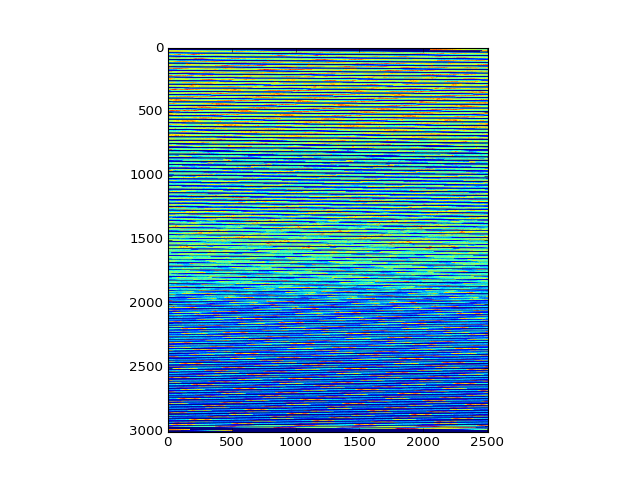

In [7]:
plt.imshow(pixel_array)

In [16]:
def get_gdcm_to_numpy_typemap():
    """Returns the GDCM Pixel Format to numpy array type mapping."""
    _gdcm_np = {gdcm.PixelFormat.UINT8  :np.int8,
                gdcm.PixelFormat.INT8   :np.uint8,
                gdcm.PixelFormat.UINT16 :np.uint16,
                gdcm.PixelFormat.INT16  :np.int16,
                gdcm.PixelFormat.UINT32 :np.uint32,
                gdcm.PixelFormat.INT32  :np.int32,
                gdcm.PixelFormat.FLOAT32:np.float32,
                gdcm.PixelFormat.FLOAT64:np.float64 }
    return _gdcm_np

def get_numpy_array_type(gdcm_pixel_format):
    """Returns a numpy array typecode given a GDCM Pixel Format."""
    return get_gdcm_to_numpy_typemap()[gdcm_pixel_format]

def gdcm_to_numpy(image):
    """Converts a GDCM image to a numpy array.
    """
    pf = image.GetPixelFormat().GetScalarType()
    print('pf', pf)
    print(image.GetPixelFormat().GetScalarTypeAsString())
    assert pf in get_gdcm_to_numpy_typemap().keys(), "Unsupported array type {}".format(pf)
    d = image.GetDimension(0), image.GetDimension(1)
    print("Image Size: {} x {}".format(d[0], d[1]))
    dtype = get_numpy_array_type(pf)
    gdcm_array = image.GetBuffer()
    result = np.frombuffer(gdcm_array, dtype=dtype)
    maxV = float(result[result.argmax()])
    ## linear gamma adjust
    #result = result + .5*(maxV-result)
    ## log gamma
    result = np.log(result+50) ## 50 is apprx background level
    maxV = float(result[result.argmax()])
    result = result*(2.**8/maxV) ## histogram stretch
    result.shape = d
    return result

In [17]:
image_reader = gdcm.ImageReader()
image_reader.SetFileName(r"D:\Clinical Graphics\X-rays\Train\4\I1000000")
if not image_reader.Read():
    raise IOError("Could not read DICOM image")
pixel_array = gdcm_to_numpy(image_reader.GetImage())

pf 4
UINT16
Image Size: 3004 x 2509


AttributeError: 'str' object has no attribute '__buffer__'

In [18]:
plt.imshow(pixel_array)